# TODO
- verificar se as porcentagens estao ok

In [63]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# Resumo da Pesquisa de Mestrado

<strong>Inspiração</strong>: o que inspirou o desenvolvimento dessa pesquisa foi o conhecimento prático deste pesquisador no dia-a-dia trabalhando na Justiça do Trabalho do Rio Grande do Sul em Porto Alegre no Brasil de que existem magistrados e Turmas Recursais que decidem majoritariamente para empregado ou para empresa, dependendo do seu viés. Tal fato é reconhecido na área de domínio por colegas de tribunal e advogados tendo até um palavra específica para representar esses magistrados. "Magistrado Reclamante" para magistrado que tem viés para empregado, e "Magistrado Reclamada" para magistrado que tem viés para empresa.

<strong>Problemática</strong>: advogados iniciantes ou de outra região do país, ou até mesmo as partes envolvidas, não detém este conhecimento empírico. No caso de processos que envolva milhões de Reais, a parte do processo que estiver melhor embasada pode tomar a melhor decisão e negociar mais efetivamente se souber qual a tendência de opinião do magistrado designado a julgar o caso.

<strong>Hipótese</strong>: "Seria possível que os tribunais avaliados e suas turmas recursais julguem favoravelmente proporção significativamente maior de recursos para uma das partes do que para outra?"

<strong>Solução proposta</strong>: 
<ol>
<li>Realizar Processo de Descoberta de Conhecimento em Bases de Dados por meio de técnicas de Mineração de Texto a fim de classificar automaticamente decisões judiciais.</li>
    Objetivos de mineração de dados:
    <ol>
    <li>Classificar automaticamente os acórdãos judiciais em relação ao deferimento ou não.
    <li>Classificar automaticamente o requerente do recurso em relação a ser empresa ou a ser empregado.
    <li>Classificar com os modelos desenvolvidos quantidade significante de decisões judiciais.
    </ol>
<li>Aplicar teste estatístico à base de decisões classificadas criada nos passos anteriores para verificar se existe diferença significativa entre a proporção de julgados favoravelmente a uma das partes.</li>
<li>Calcular o efeito estatístico entre as duas proporções de modo a prover um indicador simples do tamanho da diferença, se houver diferença estatística.</li>
</ol>

#### Este notebook trata dos itens 2 e 3.

### Teste de hipótese
<ul>
    <li>Hipótese nula (H0): Pa = Pb</li>
    <li>Hipótese alternativa (Ha): Pa &ne; Pb</li>
    <li>Pa = Proporção de processos julgados positivamente para EMPREGADOS.</li>
    <li>Pb = Proporção de processos julgados positivamente para EMPRESAS.</li>
</ul>

### Teste estatístico: Two proportion z-test.

A seguir serão realizados testes para verificar se as duas proporções são iguais (hipótese nula) ou diferentes (hipótese alternativa) de acordo com teste estatístico implementado pela biblioteca Statsmodels utilizando o método proposto por Agresti and Caffo*.
<ul>
<li><strong>Type 1 error</strong>: Quando a hipótese nula (H0) é verdadeira, mas a amostra leva a crer que não é. Pode ser medido utilizando o p-value do teste estatístico.</li>
<strong>P-value:</strong> indica a probabilidade de a hipótese nula ser verdadeira (intuitivamente falando).<br>
<strong>Nível de confiança:</strong> foi definido como 95% (valor habitualmente usado na estatística) o nível de confiança para rejeitar a hipotese nula.<br>
<strong>Nível de significancia:</strong> 1 - 0,95 = 0,05, ou seja, 5%.<br>
<strong>Análise:</strong> Se o P-value for menor que 5%, considera-se rejeitada a H0, ou seja, as duas proporções são diferentes.

<li><strong>Type 2 error</strong>: Quando a hipótese alternativa (Ha) é verdadeira, mas a amostra leva a crer que não é. Pode ser medido utilizando o "Power" do teste estatístico.</li>
<strong>Power:</strong> indica a probabilidade de encontrar uma diferença estatística quando ela existe (intuitivamente falando).<br>
<strong>Análise:</strong> Se o Power for maior que 80% (valor habitualmente usado na estatística), considera-se baixo o risco de ocorrer Type 2 error, ou seja, considera-se baixo o risco de considerar as duas proporções iguais, quando na verdade não são. O Power é altamente influenciado pelo tamanho da amostra.
</ul>
*Agresti and Caffo (2000), "Simple and Effective Confidence Intervals for Proportions and Differences of Proportions Result From Adding Two Successes and Two Failures"


### Teste de efeito estatístico: Cohen's H
Esse teste permite medir o tamanho da diferença estatística entre duas proporções, quando existente. O autor, chamado Jacob Cohen, indica a sua interpretação por meio da tabela abaixo.

|abs( Cohen h )| Interpretação|
|-------|---------------|
|0 < .50| Insignificante|
|0.20 < 0.50 |Pequeno|
|0.50 < 0.80| Médio|
|0.80 or more| Grande|

In [64]:
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot
import pandas as pd
import numpy as np
from statsmodels.stats import proportion
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import samplesize_proportions_2indep_onetail

# Limpeza e preparação dos dados

In [65]:
df = pd.read_csv( "df_classificado.csv" )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22946 entries, 0 to 22945
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   INDEX                     22946 non-null  int64  
 1   LINK                      12071 non-null  object 
 2   INTEIRO_TEOR              22946 non-null  object 
 3   DATA                      22946 non-null  object 
 4   RELATOR                   22946 non-null  object 
 5   ORGAO                     22946 non-null  object 
 6   RECORRENTE                22946 non-null  object 
 7   DISPOSITIVO               22946 non-null  object 
 8   QTD_RECORRENTES           22946 non-null  float64
 9   TRIBUNAL                  22946 non-null  object 
 10  tipo_requerente_previsto  22946 non-null  int64  
 11  deferimento_previsto      22946 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 2.1+ MB


In [66]:
df["tipo_requerente_previsto"].value_counts()

1    17525
0     5421
Name: tipo_requerente_previsto, dtype: int64

### Ajuste campo tipo requerente

In [67]:
EMPRESA = 0
EMPREGADO = 1

In [68]:
df["tipo_requerente_previsto"] = df["tipo_requerente_previsto"].replace(EMPREGADO, "EMPREGADO")
df["tipo_requerente_previsto"] = df["tipo_requerente_previsto"].replace(EMPRESA, "EMPRESA")
df["tipo_requerente_previsto"].value_counts()

EMPREGADO    17525
EMPRESA       5421
Name: tipo_requerente_previsto, dtype: int64

### Ajuste campo deferimento

In [69]:
df["deferimento_previsto"].value_counts()

0    12354
1     9970
2      622
Name: deferimento_previsto, dtype: int64

In [70]:
INDEFERIMENTO = 0
DEFERIMENTO = 1

In [71]:
df["deferimento_previsto"] = df["deferimento_previsto"].replace(INDEFERIMENTO, "INDEFERIMENTO")
df["deferimento_previsto"] = df["deferimento_previsto"].replace(DEFERIMENTO, "DEFERIMENTO")
df["deferimento_previsto"].value_counts()

INDEFERIMENTO    12354
DEFERIMENTO       9970
2                  622
Name: deferimento_previsto, dtype: int64

#### Remoção de observações desnecessárias
Remoção das observações do tipo 2, a saber, são as observações que não tiveram julgamento final devido a algum problema processual.
<br>Manutenção apenas das linhas com a palavra "Turma", pois existem órgão que também julgam no Tribunal, mas são tipos diferentes de julgamentos, não interessantes para a pesquisa.
<br>São mantidos apenas as colunas necessárias para realizar a análise propostas. Assim, os textos das decisões em si são removidos, o que diminui o tamanho do dataset em memória.

In [72]:
deferimento = df["deferimento_previsto"] != 2
orgao = df["ORGAO"].str.contains("Turma")
df_limpo = df.loc[ deferimento & orgao, ['DATA', 'RELATOR', 'ORGAO', 'QTD_RECORRENTES', 'TRIBUNAL', 'tipo_requerente_previsto', 'deferimento_previsto'] ]
#df_limpo.to_csv("df_limpo.csv", encoding='utf-8', index=False )

In [73]:
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21828 entries, 0 to 22945
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATA                      21828 non-null  object 
 1   RELATOR                   21828 non-null  object 
 2   ORGAO                     21828 non-null  object 
 3   QTD_RECORRENTES           21828 non-null  float64
 4   TRIBUNAL                  21828 non-null  object 
 5   tipo_requerente_previsto  21828 non-null  object 
 6   deferimento_previsto      21828 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.3+ MB


### Ajuste dos nomes das turmas recursais

In [74]:
df_limpo["ORGAO"].unique()

array(['3ª Turma', '1ª Turma', '6ª Turma', '5ª Turma', '7ª Turma',
       '2ª Turma', '8ª Turma', '4ª Turma', '10ª Turma', '9ª Turma',
       '11ª Turma', 'Segunda Turma', 'Terceira Turma', 'Setima Turma',
       'Quarta Turma', 'Nona Turma', 'Decima Primeira Turma',
       'Oitava Turma', 'Primeira Turma', 'Quinta Turma', 'Sexta Turma',
       'Decima Turma'], dtype=object)

In [75]:
df_limpo["ORGAO"] = df_limpo["ORGAO"].replace('Segunda Turma', '2ª Turma')
df_limpo["ORGAO"] = df_limpo["ORGAO"].replace('Terceira Turma', '3ª Turma')
df_limpo["ORGAO"] = df_limpo["ORGAO"].replace('Setima Turma', '7ª Turma')
df_limpo["ORGAO"] = df_limpo["ORGAO"].replace('Quarta Turma', '4ª Turma')
df_limpo["ORGAO"] = df_limpo["ORGAO"].replace('Nona Turma', '9ª Turma')
df_limpo["ORGAO"] = df_limpo["ORGAO"].replace('Decima Primeira Turma', '11ª Turma')
df_limpo["ORGAO"] = df_limpo["ORGAO"].replace('Oitava Turma', '8ª Turma')
df_limpo["ORGAO"] = df_limpo["ORGAO"].replace('Primeira Turma', '1ª Turma')
df_limpo["ORGAO"] = df_limpo["ORGAO"].replace('Quinta Turma', '5ª Turma')
df_limpo["ORGAO"] = df_limpo["ORGAO"].replace('Sexta Turma', '6ª Turma')
df_limpo["ORGAO"] = df_limpo["ORGAO"].replace('Decima Turma', '10ª Turma')
df_limpo["ORGAO"].unique()

array(['3ª Turma', '1ª Turma', '6ª Turma', '5ª Turma', '7ª Turma',
       '2ª Turma', '8ª Turma', '4ª Turma', '10ª Turma', '9ª Turma',
       '11ª Turma'], dtype=object)

### Construção de dataframes auxiliares

In [76]:
#utilizado para construção de gráficos e testes estatísticos

#precisa fazer todo este processo abaixo, pq o agrupamento pode gerar grupos que tenham pouca quantidade de processos julgados e nao tendo nenhum julgado para um dos tipos faz dar erro no cálculo de porcentagem nas células porsteriores.
#por isso, completamos com 0 para as células posteriores poderem ter um valor pra somar.

_tribunal_TRT4 = df_limpo["TRIBUNAL"] == "TRT4"
df_quantidades_TRT4 = df_limpo.loc[ _tribunal_TRT4, : ].groupby( [ "TRIBUNAL", "ORGAO", "tipo_requerente_previsto", "deferimento_previsto" ])["deferimento_previsto"].count().unstack(fill_value=0).stack().to_frame().rename(columns={0:'QUANTIDADE'}).unstack(level=-2, fill_value=0).stack()
df_quantidades_TRT4.reset_index( inplace=True)

_tribunal_TRT3 = df_limpo["TRIBUNAL"] == "TRT3"
df_quantidades_TRT3 = df_limpo.loc[ _tribunal_TRT3, : ].groupby( [ "TRIBUNAL", "ORGAO", "tipo_requerente_previsto", "deferimento_previsto" ])["deferimento_previsto"].count().unstack(fill_value=0).stack().to_frame().rename(columns={0:'QUANTIDADE'}).unstack(level=-2, fill_value=0).stack()
df_quantidades_TRT3.reset_index( inplace=True)

In [77]:
#utilizado para testes estatísticos

#define função para criar tabela de frequencia normalizada em percentuais em relação a cada turma recursal.
#Quem sabe poderia ter usado o pd.crosstab, mas acabei fazendo na mão mesmo....

def cria_df_quantidades_percentuais( nome_tribunal, df_quantidades ):
    df_temp = pd.DataFrame()
    
    _tribunal = df_quantidades["TRIBUNAL"] == nome_tribunal
    
    _deferimento = df_quantidades["deferimento_previsto"] == "DEFERIMENTO"
    _indeferimento = df_quantidades["deferimento_previsto"] == "INDEFERIMENTO"
    _tipo_requerente_EMPREGADO = df_quantidades["tipo_requerente_previsto"] == "EMPREGADO"
    _tipo_requerente_EMPRESA = df_quantidades["tipo_requerente_previsto"] == "EMPRESA"
    
    for nome_orgao in df_quantidades.loc[ _tribunal, "ORGAO" ].unique():
        #print(nome_orgao)
        _orgao = df_quantidades.loc[ _tribunal, "ORGAO" ] == nome_orgao

        #porcentagem EMPREGADO DEFERIMENTO
        qtd_deferimento_empregado = df_quantidades.loc[ _tribunal & _orgao & _deferimento &  _tipo_requerente_EMPREGADO, "QUANTIDADE" ].iloc[0]
        qtd_indeferimento_empregado = df_quantidades.loc[ _tribunal & _orgao & _indeferimento &  _tipo_requerente_EMPREGADO, "QUANTIDADE" ].iloc[0]

        total = qtd_deferimento_empregado + qtd_indeferimento_empregado
        percentual_deferimento = ( qtd_deferimento_empregado / total ) * 100

        nova_linha = {"TRIBUNAL": nome_tribunal, "ORGAO": nome_orgao, "tipo_requerente_previsto": "EMPREGADO", "percentual_deferido": percentual_deferimento}
        #print(nova_linha)
        df_temp = df_temp.append(nova_linha, ignore_index=True)

        #porcentagem EMPRESA DEFERIMENTO
        qtd_deferimento_empresa = df_quantidades.loc[ _tribunal & _orgao & _deferimento &  _tipo_requerente_EMPRESA, "QUANTIDADE" ].iloc[0]
        qtd_indeferimento_empresa = df_quantidades.loc[ _tribunal & _orgao & _indeferimento &  _tipo_requerente_EMPRESA, "QUANTIDADE" ].iloc[0]

        total = qtd_deferimento_empresa + qtd_indeferimento_empresa
        percentual_deferimento = ( qtd_deferimento_empresa / total ) * 100

        nova_linha = {"TRIBUNAL": nome_tribunal, "ORGAO": nome_orgao, "tipo_requerente_previsto": "EMPRESA", "percentual_deferido": percentual_deferimento}
        #print(nova_linha)
        df_temp = df_temp.append(nova_linha, ignore_index=True)
    return df_temp

In [78]:
df_quantidades_percentuais_TRT4 = pd.DataFrame()
df_quantidades_percentuais_TRT3 = pd.DataFrame()

df_quantidades_percentuais_TRT4 = cria_df_quantidades_percentuais( "TRT4", df_quantidades_TRT4 )
df_quantidades_percentuais_TRT3 = cria_df_quantidades_percentuais( "TRT3", df_quantidades_TRT3 )

### Ordenação dos dataframes
Serve para que os gráficos fiquem na ordem do número das turmas recursais.
<br>**Importante: os nomes das turmas recursais tem que estar escritos na forma de números em vez de por extenso. Exemplo: 11ª Turma Recursal.

In [79]:
#precisa ordenar na ordem inversa, pq os gráficos são inseridos no plotly nessa ordem, e daí são exibidos na ordem inversa, o que faz com que eles fiquem na ordem desejada.
df_quantidades_TRT4["NUMERO_ORDEM"] = df_quantidades_TRT4["ORGAO"].str.extract('(\d+)')
df_quantidades_TRT4["NUMERO_ORDEM"] = df_quantidades_TRT4["NUMERO_ORDEM"].astype(int)
df_quantidades_TRT4 = df_quantidades_TRT4.sort_values([ "NUMERO_ORDEM", "tipo_requerente_previsto", "deferimento_previsto" ], ascending=[ False, True, False ])

df_quantidades_TRT3["NUMERO_ORDEM"] = df_quantidades_TRT3["ORGAO"].str.extract('(\d+)')
df_quantidades_TRT3["NUMERO_ORDEM"] = df_quantidades_TRT3["NUMERO_ORDEM"].astype(int)
df_quantidades_TRT3 = df_quantidades_TRT3.sort_values([ "NUMERO_ORDEM", "tipo_requerente_previsto", "deferimento_previsto" ], ascending=[ False, True, False ])

In [80]:
#precisa ordenar na ordem inversa, pq os gráficos são inseridos no plotly nessa ordem, e daí são exibidos na ordem inversa, o que faz com que eles fiquem na ordem desejada.
df_quantidades_percentuais_TRT4["NUMERO_ORDEM"] = df_quantidades_percentuais_TRT4["ORGAO"].str.extract('(\d+)')
df_quantidades_percentuais_TRT4["NUMERO_ORDEM"] = df_quantidades_percentuais_TRT4["NUMERO_ORDEM"].astype(int)
df_quantidades_percentuais_TRT4 = df_quantidades_percentuais_TRT4.sort_values([ "NUMERO_ORDEM", "tipo_requerente_previsto" ], ascending=[ False, True ])

df_quantidades_percentuais_TRT3["NUMERO_ORDEM"] = df_quantidades_percentuais_TRT3["ORGAO"].str.extract('(\d+)')
df_quantidades_percentuais_TRT3["NUMERO_ORDEM"] = df_quantidades_percentuais_TRT3["NUMERO_ORDEM"].astype(int)
df_quantidades_percentuais_TRT3 = df_quantidades_percentuais_TRT3.sort_values([ "NUMERO_ORDEM", "tipo_requerente_previsto" ], ascending=[ False, True ])

# Análise de Dados Gráfica

# TRT 4 - Análise do tribunal de modo geral
## Proporção de deferimentos e indeferimentos para ambas as partes

In [81]:
_tribunal_TRT4 = df_limpo["TRIBUNAL"] == "TRT4"
X_def = pd.crosstab( df_limpo.loc[ _tribunal_TRT4 ].tipo_requerente_previsto, df_limpo.loc[ _tribunal_TRT4 ].deferimento_previsto ).loc[ :, "DEFERIMENTO" ]
X_indef = pd.crosstab( df_limpo.loc[ _tribunal_TRT4 ].tipo_requerente_previsto, df_limpo.loc[ _tribunal_TRT4 ].deferimento_previsto ).loc[ :, "INDEFERIMENTO" ]
rotulos = [ "EMPREGADO", "EMPRESA" ]

In [82]:
porporcao_empregado, porporcao_empresa  = pd.crosstab( df_limpo.loc[ _tribunal_TRT4 ].tipo_requerente_previsto, df_limpo.loc[ _tribunal_TRT4 ].deferimento_previsto ).apply(lambda r:r/r.sum(),axis=1).loc[ :,  "DEFERIMENTO" ].to_numpy().flatten()

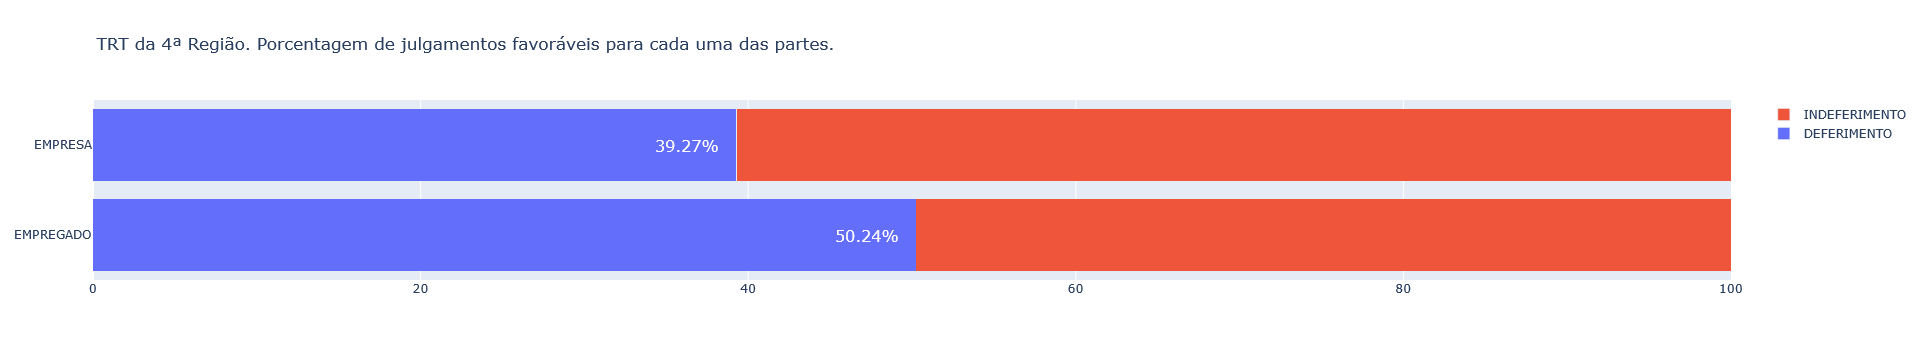

In [83]:
#DEFERIMENTO
trace1 = go.Bar(x = X_def,
                y = rotulos,  
                orientation="h",
                textposition='auto',
                textfont=dict(
        family="sans serif",
        size=18,
        color="black"),
                name="DEFERIMENTO" )
#INDEFERIMENTO
trace2 = go.Bar(x = X_indef,
                y = rotulos,
                orientation="h",
                textposition='auto',
                name="INDEFERIMENTO" )

layout = go.Layout( title="TRT da 4ª Região. Porcentagem de julgamentos favoráveis para cada uma das partes.",
                    barmode="stack",
                    barnorm="percent",                    
                    )

fig = go.Figure( data = [ trace1, trace2 ], layout=layout )

fig.add_annotation(
        y="EMPREGADO",
        x = ( porporcao_empregado*100 ) - 3,
        text=str( round( porporcao_empregado*100, 2) )+"%",
        showarrow=False,
        font=dict(
                size=16,
                color="#ffffff"
                ),
        )

fig.add_annotation(
        y="EMPRESA",
        x = ( porporcao_empresa*100 ) - 3,
        text=str( round( porporcao_empresa*100, 2) )+"%",
        showarrow=False,
        font=dict(
                size=16,
                color="#ffffff"
                ),
        )

fig.show()

### Interpretação
Do total de recursos que as <strong>EMPRESAS</strong> recorreram ao TRT da 4ª Região, <strong>39,27%</strong> foram DEFERIDOS. Considerando apenas sentenças em que houve recurso somente da EMPRESA.<BR>
Do total de recursos que as <strong>EMPREGADOS</strong> recorreram ao TRT da 4ª Região, <strong>50,24%</strong> foram DEFERIDOS. Considerando apenas sentenças em que houve recurso somente do EMPREGADO.<BR>

In [84]:
print( "Quantidade de processos analisados: "+str( len( df_limpo.loc[ _tribunal_TRT4 ] ) ) )

Quantidade de processos analisados: 11351


In [85]:
tipo_requerente_previsto_EMPREGADO = df_limpo["tipo_requerente_previsto"] == "EMPREGADO"
tipo_requerente_previsto_EMPRESA = df_limpo["tipo_requerente_previsto"] == "EMPRESA"
quantidade_EMPREGADO = len( df_limpo.loc[ _tribunal_TRT4 & tipo_requerente_previsto_EMPREGADO ] )
quantidade_EMPRESA = len( df_limpo.loc[ _tribunal_TRT4 & tipo_requerente_previsto_EMPRESA ] )
print( "Recorrente EMPREGADO. Quantidade de processos analisados: "+str( quantidade_EMPREGADO ) )
print( "Recorrente EMPRESA. Quantidade de processos analisados: "+str( quantidade_EMPRESA ) )

Recorrente EMPREGADO. Quantidade de processos analisados: 9398
Recorrente EMPRESA. Quantidade de processos analisados: 1953


## Teste estatístico: Two proportion z-test
### Interpretação

In [86]:
n_deferimento_empregado, n_indeferimento_empregado, n_deferimento_empresa, n_indeferimento_empresa =  pd.crosstab( df_limpo.loc[ _tribunal_TRT4 ].tipo_requerente_previsto, df_limpo.loc[ _tribunal_TRT4 ].deferimento_previsto ).to_numpy().flatten()
total_empregado = n_deferimento_empregado + n_indeferimento_empregado
total_empresa = n_deferimento_empresa + n_indeferimento_empresa
pvalue = proportion.test_proportions_2indep( n_deferimento_empregado, total_empregado, n_deferimento_empresa, total_empresa )[1]

In [87]:
print( "P-value: "+str(round(pvalue*100, 2) )+"%" )
if( pvalue < 0.05 ):
    print( "SIM, apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa." )
else:
    print( "NÃO, não apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa." )

P-value: 0.0%
SIM, apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa.


In [88]:
pvalue

2.4375333183946957e-19

In [89]:
P1 = n_deferimento_empregado / total_empregado
P2 = n_deferimento_empresa / total_empresa
diff = P1 - P2
power = proportion.power_proportions_2indep( diff, P2, total_empregado,  total_empresa/total_empregado, alpha=0.05, value=0, alternative='two-sided', return_results=True).power
print( "Power: "+str(round(power*100, 2) )+"%" )
if( power < 0.8 ):
    print( "Nível inaceitável de força estatística. Risco considerável de ocorrer Type 2 error, ou seja, há risco de não haver diferença entre as proporções (se foi encontrada diferença)." )
else:
    print( "Nível aceitável de força estatística. Risco baixo de ocorrer Type 2 error, ou seja, há risco baixo de não haver diferença entre as proporções (se foi encontrada diferença)." )

Power: 100.0%
Nível aceitável de força estatística. Risco baixo de ocorrer Type 2 error, ou seja, há risco baixo de não haver diferença entre as proporções (se foi encontrada diferença).


## Teste de efeito estatístico: Cohen's H
### Interpretação

In [90]:
effectsize = proportion_effectsize( porporcao_empregado, porporcao_empresa )

In [91]:
print( "Índice Cohen's H: "+str(abs(round(effectsize*100, 2) ) )+"%" )
hNonDir = abs(effectsize)
if hNonDir < .20:
    print('Diferença estatística insignificante.')
elif hNonDir < .50:
    print('Diferença estatística pequena.')
elif hNonDir < .80:
    print('Diferença estatística média.')
else:
    print('Diferença estatística grande.')    

Índice Cohen's H: 22.11%
Diferença estatística pequena.


# TRT 4 - Análise das Turmas Recursais individualmente

In [92]:
_tribunal_TRT4 = df_quantidades_TRT4["TRIBUNAL"] == "TRT4"
_polaridade_def = df_quantidades_TRT4["deferimento_previsto"] == "DEFERIMENTO"
_polaridade_indef = df_quantidades_TRT4["deferimento_previsto"] == "INDEFERIMENTO"

X_def = df_quantidades_TRT4.loc[ _tribunal_TRT4 & _polaridade_def , "QUANTIDADE" ]
Y_def_orgao = df_quantidades_TRT4.loc[ _tribunal_TRT4 & _polaridade_def , "ORGAO" ]
Y_def_recorrente = df_quantidades_TRT4.loc[ _tribunal_TRT4 & _polaridade_def , "tipo_requerente_previsto" ]

X_indef = df_quantidades_TRT4.loc[ _tribunal_TRT4 & _polaridade_indef , "QUANTIDADE" ]
Y_indef_orgao = df_quantidades_TRT4.loc[ _tribunal_TRT4 & _polaridade_indef , "ORGAO" ]
Y_indef_recorrente = df_quantidades_TRT4.loc[ _tribunal_TRT4 & _polaridade_indef , "tipo_requerente_previsto" ]

In [93]:
#deferido
trace1 = go.Bar(x = X_def,
                y = [ Y_def_orgao,
                      Y_def_recorrente ],  
                orientation="h",
                name="DEFERIMENTO" )
#indeferido
trace2 = go.Bar(x = X_indef,
                y = [ Y_indef_orgao,
                      Y_indef_recorrente ],
                orientation="h",
                name="INDEFERIMENTO" )

layout = go.Layout( 
    title="TRT da 4ª Região. Porcentagem de julgamentos favoráveis <br>para cada uma das partes em relação a cada Turma Recursal.",
    barmode="stack",
    barnorm="percent",
    margin=dict(l=400),
    width=1000,
    height=1000
    )

fig = go.Figure( data = [ trace1, trace2 ], layout=layout )

In [94]:
_tribunal_TRT4 = df_quantidades_percentuais_TRT4["TRIBUNAL"] == "TRT4"
orgaos = df_quantidades_percentuais_TRT4.loc[ _tribunal_TRT4, "ORGAO"].to_numpy()
percentuais_deferimento = df_quantidades_percentuais_TRT4.loc[ _tribunal_TRT4, "percentual_deferido"].to_numpy()
tipo_parte = df_quantidades_percentuais_TRT4.loc[ _tribunal_TRT4, "tipo_requerente_previsto"].to_numpy()

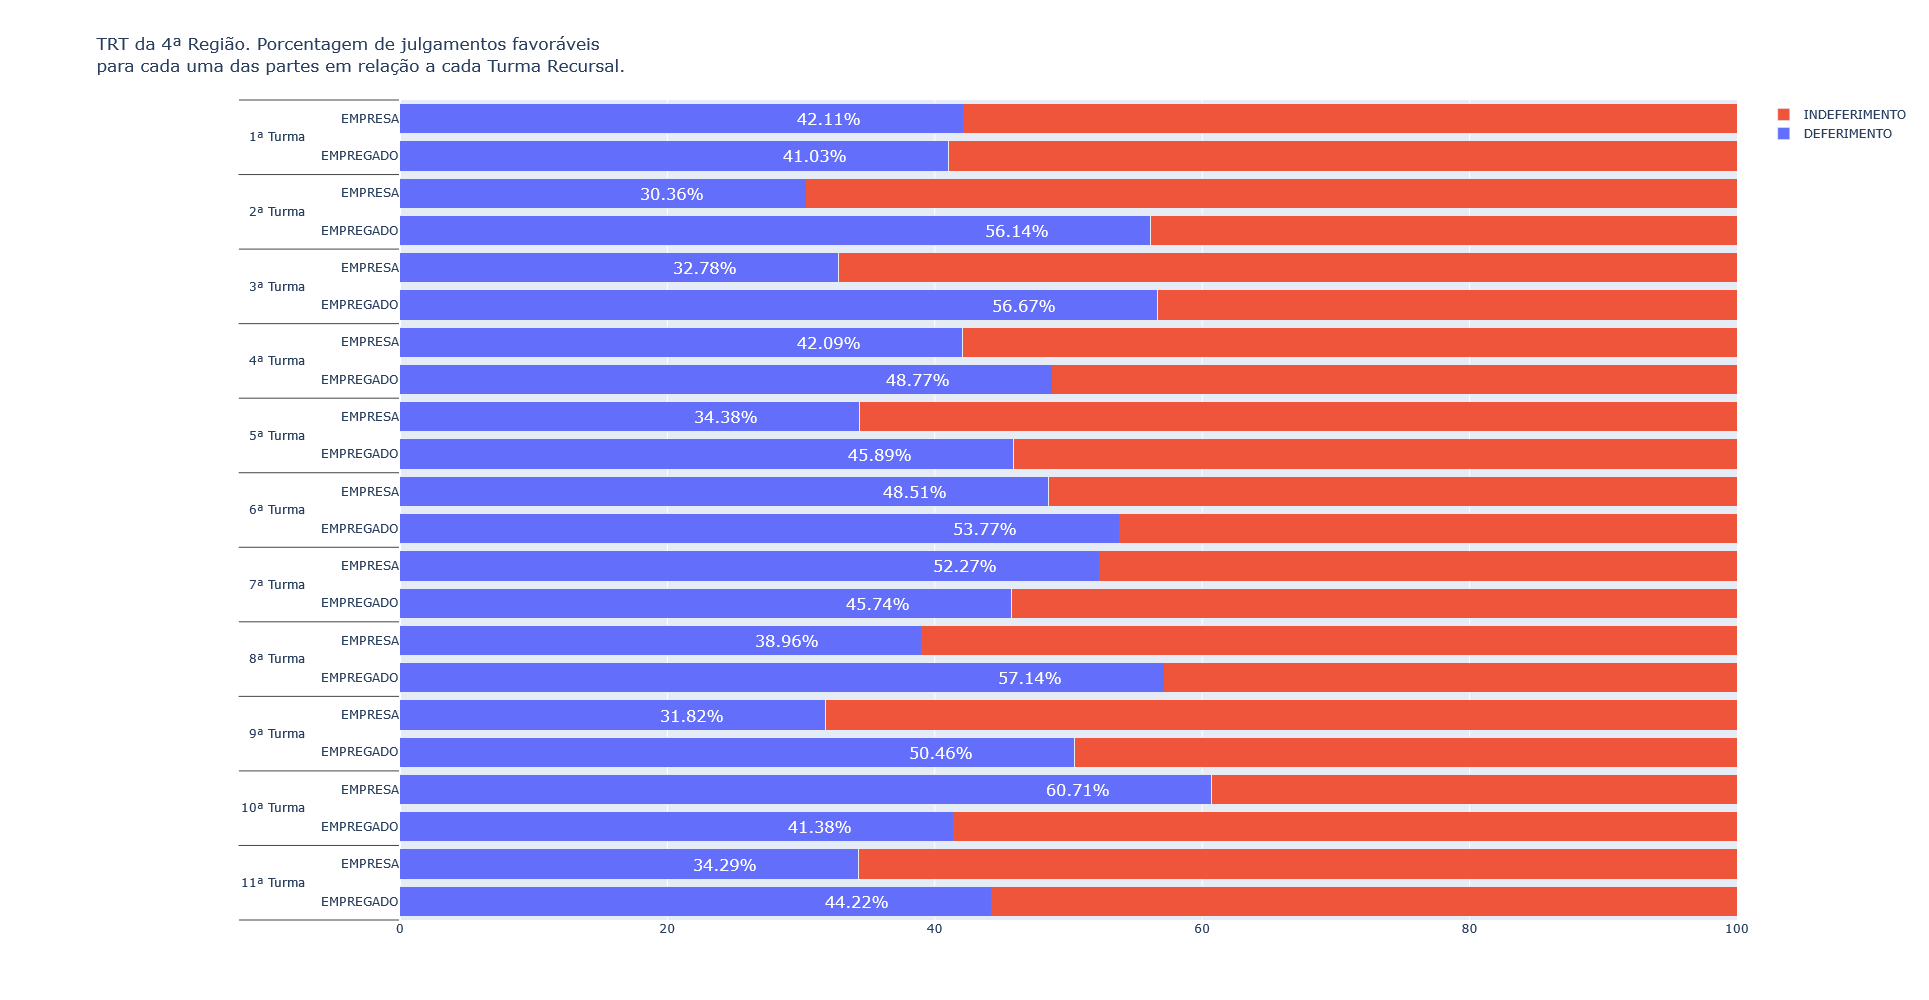

In [95]:
for i in range( len( orgaos ) ):
    fig.add_annotation(
            y= [ orgaos[i], tipo_parte[i] ],
            x = ( percentuais_deferimento[i] ) - 10,
            text=str( round( percentuais_deferimento[i], 2) )+"%",
            showarrow=False,
            font=dict(
                    size=16,
                    color="#ffffff"
                    ),
            )

fig.show()

### Interpretação
O gráfico anterior apresenta as porcentagens de deferimento em relação a cada Turma Recursal em relação a parte sendo empregado e empresa.

## Teste estatístico: Two proportion z-test e Teste de efeito estatístico: Cohen's H para cada Turma Recursal
### Interpretação

In [96]:
#realiza testes estatísticos para cada turma recursal
def testes_estatisticos_turmas( tribunal, df_quantidades ):
    df_quantidades = df_quantidades.sort_values([ "NUMERO_ORDEM", "tipo_requerente_previsto", "deferimento_previsto" ], ascending=[ True, True, True ])
    df_relatorio = pd.DataFrame()
    _tribunal = df_quantidades["TRIBUNAL"] == tribunal

    for turma_recursal in df_quantidades.loc[ _tribunal, "ORGAO" ].unique():
        _turma_recursal = df_quantidades["ORGAO"] == turma_recursal
        _tipo_requerente_empregado = df_quantidades["tipo_requerente_previsto"] == "EMPREGADO"
        _tipo_requerente_empresa = df_quantidades["tipo_requerente_previsto"] == "EMPRESA"

        n_deferimento_empregado = df_quantidades.loc[ _turma_recursal &  _tipo_requerente_empregado, "QUANTIDADE" ].to_numpy()[0]
        n_indeferimento_empregado = df_quantidades.loc[ _turma_recursal &  _tipo_requerente_empregado, "QUANTIDADE" ].to_numpy()[1]
        total_empregado = n_deferimento_empregado + n_indeferimento_empregado

        n_deferimento_empresa = df_quantidades.loc[ _turma_recursal &  _tipo_requerente_empresa, "QUANTIDADE" ].to_numpy()[0]
        n_indeferimento_empresa = df_quantidades.loc[ _turma_recursal &  _tipo_requerente_empresa, "QUANTIDADE" ].to_numpy()[1]
        total_empresa = n_deferimento_empresa + n_indeferimento_empresa

        pvalue = proportion.test_proportions_2indep( n_deferimento_empregado, total_empregado, n_deferimento_empresa, total_empresa )[1]

        print( "=======================================> "+turma_recursal )
        print( "Quantidade de processos analisados de EMPRESAS: "+str(total_empresa) )
        print( "Quantidade de processos analisados de EMPREGADOS: "+str(total_empregado) )

        ###### P-VALUE
        print( "===> P-value: "+str(round(pvalue*100, 2) )+"%" )
        pvalue_interpretacao = ""
        if( pvalue < 0.05 ):
            print( "SIM, apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa." )
            #pvalue_interpretacao = "SIM, HÁ DIFERENÇA ESTATÍSTICA"
            pvalue_interpretacao = "HÁ DIFERENÇA"
        else:
            print( "NÃO, não apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa." )
            #pvalue_interpretacao = "NÃO, NÃO HÁ DIFERENÇA ESTATÍSTICA"
            pvalue_interpretacao = "NÃO HÁ DIFERENÇA"

        ###### POWER
        P1 = n_deferimento_empregado / total_empregado
        P2 = n_deferimento_empresa / total_empresa
        diff = P1 - P2
        power = proportion.power_proportions_2indep( diff, P2, total_empregado,  total_empresa/total_empregado, alpha=0.05, value=0, alternative='two-sided', return_results=True).power
        print( "===> Power: "+str(round(power*100, 2) )+"%" )
        power_interpretacao = ""
        if( power < 0.8 ):
            print( "Nível inaceitável de força estatística. Risco considerável de ocorrer Type 2 error, ou seja, há risco de não haver diferença entre as proporções (se foi encontrada diferença)." )
            #power_interpretacao = "FORÇA ESTATÍSTICA INACEITÁVEL"
            power_interpretacao = "INACEITÁVEL"
        else:
            print( "Nível aceitável de força estatística. Risco baixo de ocorrer Type 2 error, ou seja, há risco baixo de não haver diferença entre as proporções (se foi encontrada diferença)." )
            #power_interpretacao = "FORÇA ESTATÍSTICA ACEITÁVEL"
            power_interpretacao = "ACEITÁVEL"

         ###### COHEN'S H   
        effectsize = proportion_effectsize( P1, P2 )
        print( "===> Índice Cohen's H: "+str(abs(round(effectsize*100, 2) ) )+"%" )
        hNonDir = abs(effectsize)
        effectsize_interpretacao = ""
        if hNonDir < .20:
            print('Diferença estatística insignificante.')
            #effectsize_interpretacao = "DIFERENÇA DE PROPORÇÃO INSIGNIFICANTE"
            effectsize_interpretacao = "INSIGNIFICANTE"
        elif hNonDir < .50:
            print('Diferença estatística pequena.')
            #effectsize_interpretacao = "DIFERENÇA DE PROPORÇÃO PEQUENA"
            effectsize_interpretacao = "PEQUENA"
        elif hNonDir < .80:
            print('Diferença estatística média.')
            #effectsize_interpretacao = "DIFERENÇA DE PROPORÇÃO MÉDIA"
            effectsize_interpretacao = "MÉDIA"
        else:
            print('Diferença estatística grande.')    
            #effectsize_interpretacao = "DIFERENÇA DE PROPORÇÃO GRANDE"
            effectsize_interpretacao = "GRANDE"

        #print( "------------" )
        print( "" )
        total_processos = total_empregado+total_empresa
        linha = [ tribunal, turma_recursal, total_processos, round(pvalue, 4), pvalue_interpretacao, round(power, 4), power_interpretacao, abs(round(effectsize, 4)), effectsize_interpretacao ]
        df_relatorio = df_relatorio.append( [linha] )
        
    df_relatorio.columns = [ "TRIBUNAL", "TURMA RECURSAL", "TOTAL DE PROCESSOS", "PVALUE", "PVALUE INTERPRETACAO", "POWER", "POWER INTERPRETAÇÃO", "EFFECT", "EFFECT INTERPRETACAO" ]
    return df_relatorio

In [97]:
df_relatorio_trt4 = testes_estatisticos_turmas( "TRT4", df_quantidades_TRT4 )

=======================================> 1ª Turma
Quantidade de processos analisados de EMPRESAS: 323
Quantidade de processos analisados de EMPREGADOS: 1316
===> P-value: 71.72%
NÃO, não apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa.
===> Power: 8.63%
Nível inaceitável de força estatística. Risco considerável de ocorrer Type 2 error, ou seja, há risco de não haver diferença entre as proporções (se foi encontrada diferença).
===> Índice Cohen's H: 2.17%
Diferença estatística insignificante.

=======================================> 2ª Turma
Quantidade de processos analisados de EMPRESAS: 247
Quantidade de processos analisados de EMPREGADOS: 1457
===> P-value: 0.0%
SIM, apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa.
===> Power: 100.0%
Nível aceitável de força estatística. Risco baixo de ocorrer Type 2 error, ou seja, há risco baixo de não haver diferença entre as proporções (se foi encontr

In [98]:
df_relatorio_trt4

,TRIBUNAL,TURMA RECURSAL,TOTAL DE PROCESSOS,PVALUE,PVALUE INTERPRETACAO,POWER,POWER INTERPRETAÇÃO,EFFECT,EFFECT INTERPRETACAO
0,TRT4,1ª Turma,1639,0.7172,NÃO HÁ DIFERENÇA,0.0863,INACEITÁVEL,0.0217,INSIGNIFICANTE
0,TRT4,2ª Turma,1704,0.0000,HÁ DIFERENÇA,1.0000,ACEITÁVEL,0.5267,MÉDIA
0,TRT4,3ª Turma,1832,0.0000,HÁ DIFERENÇA,1.0000,ACEITÁVEL,0.4853,PEQUENA
0,TRT4,4ª Turma,1800,0.0343,HÁ DIFERENÇA,0.9575,ACEITÁVEL,0.1343,INSIGNIFICANTE
0,TRT4,5ª Turma,1504,0.0003,HÁ DIFERENÇA,0.9999,ACEITÁVEL,0.2355,PEQUENA
0,TRT4,6ª Turma,1171,0.1741,NÃO HÁ DIFERENÇA,0.6380,INACEITÁVEL,0.1051,INSIGNIFICANTE
0,TRT4,7ª Turma,825,0.1687,NÃO HÁ DIFERENÇA,0.6817,INACEITÁVEL,0.1307,INSIGNIFICANTE
0,TRT4,8ª Turma,448,0.0032,HÁ DIFERENÇA,0.9988,ACEITÁVEL,0.3660,PEQUENA
0,TRT4,9ª Turma,131,0.1106,NÃO HÁ DIFERENÇA,0.8029,ACEITÁVEL,0.3813,PEQUENA
0,TRT4,10ª Turma,115,0.0752,NÃO HÁ DIFERENÇA,0.7266,INACEITÁVEL,0.3892,PEQUENA


In [99]:
df_relatorio_trt4.to_csv("df_relatorio_trt4.csv", sep=',', encoding='utf-8', quotechar='"', decimal=',')

In [100]:
df_relatorio_trt4.describe()

,TOTAL DE PROCESSOS,PVALUE,POWER,EFFECT
count,11.000000,11.000000,11.000000,11.000000
mean,1031.909091,0.143973,0.755073,0.270873
std,710.707880,0.213136,0.294280,0.167418
min,115.000000,0.000000,0.086300,0.021700
25%,315.000000,0.001750,0.659850,0.132500
50%,1171.000000,0.075200,0.802900,0.235500
75%,1671.500000,0.171400,0.999350,0.385250
max,1832.000000,0.717200,1.000000,0.526700


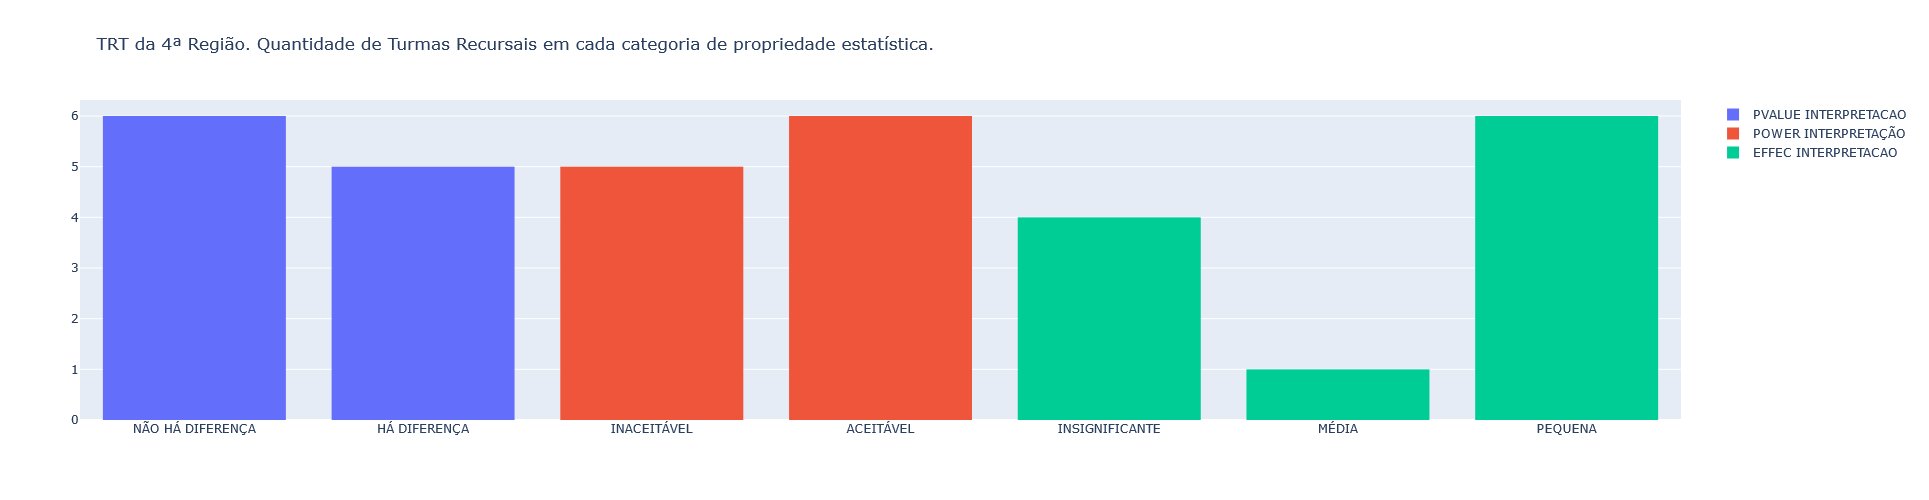

In [101]:
x_pvalue = df_relatorio_trt4["PVALUE INTERPRETACAO"]
x_power = df_relatorio_trt4["POWER INTERPRETAÇÃO"]
x_effect = df_relatorio_trt4["EFFECT INTERPRETACAO"]

trace1 = go.Histogram(
    x=x_pvalue,
    name="PVALUE INTERPRETACAO",
)

trace2 = go.Histogram(
    x=x_power,
    name="POWER INTERPRETAÇÃO",
)

trace3 = go.Histogram(
    x=x_effect,
    name="EFFEC INTERPRETACAO",
)

layout = go.Layout( title="TRT da 4ª Região. Quantidade de Turmas Recursais em cada categoria de propriedade estatística.",
                   #width=1000,
                   height=500
                  )

fig = go.Figure( data = [ trace1, trace2, trace3 ], layout=layout )
fig.show()

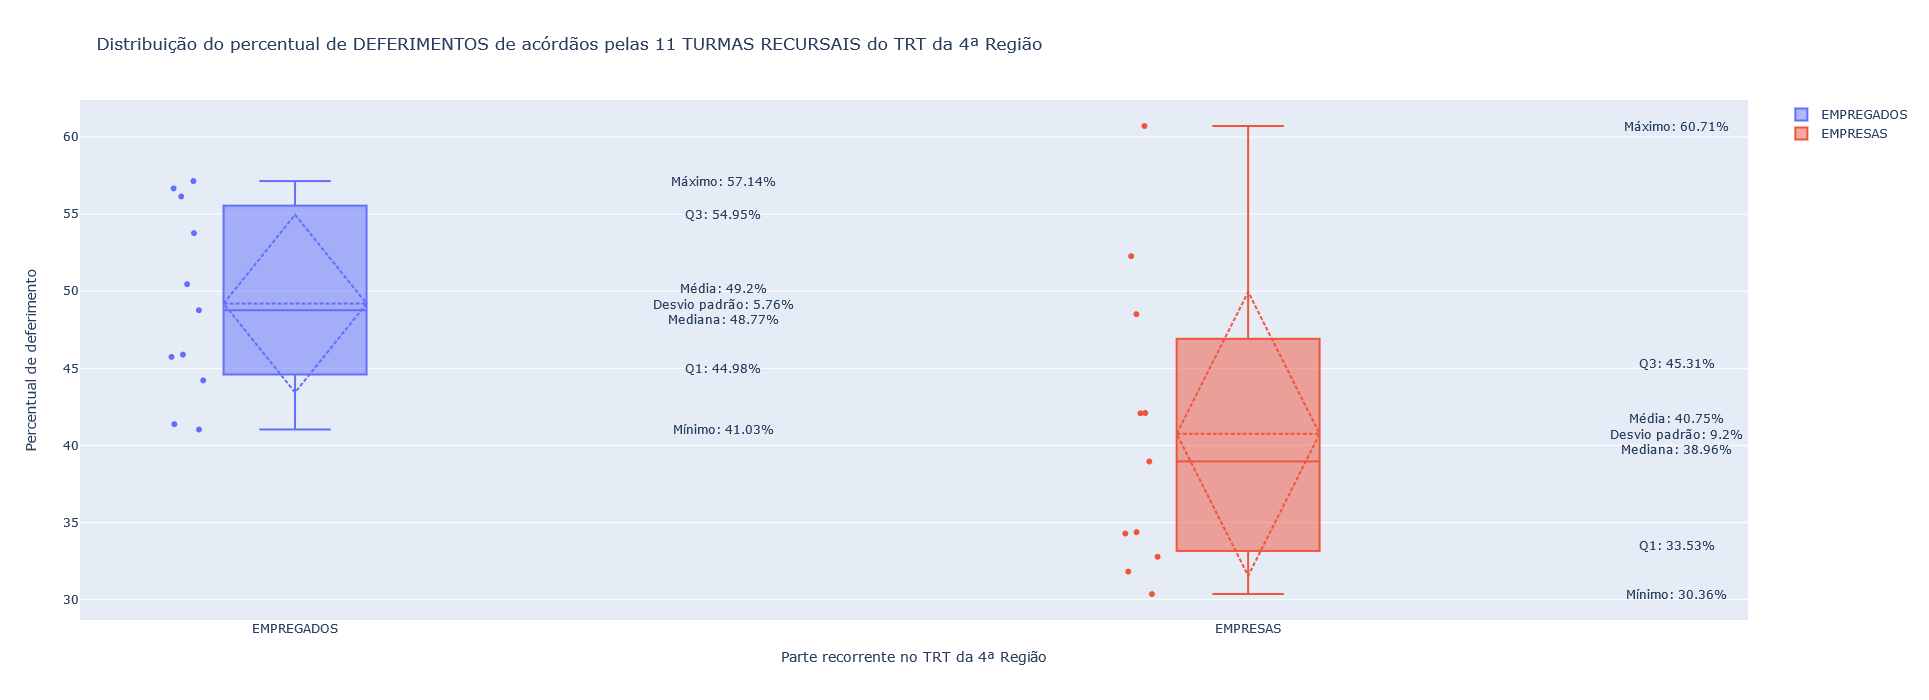

In [102]:
df_quantidades_percentuais = df_quantidades_percentuais_TRT4

_tipo_requerente_EMPREGADO = df_quantidades_percentuais["tipo_requerente_previsto"] == "EMPREGADO"
_tipo_requerente_EMPRESA = df_quantidades_percentuais["tipo_requerente_previsto"] == "EMPRESA"
_tribunal = df_quantidades_percentuais["TRIBUNAL"] == "TRT4"

layout = go.Layout(
    title='Distribuição do percentual de DEFERIMENTOS de acórdãos pelas 11 TURMAS RECURSAIS do TRT da 4ª Região',
    yaxis_title_text='Percentual de deferimento',
    xaxis_title_text='Parte recorrente no TRT da 4ª Região',
    width=1000,
    height=700,
    #boxgap=1
)

box_width = 0.15

########## EMPREGADOS
y_empregado = df_quantidades_percentuais.loc[ _tribunal & _tipo_requerente_EMPREGADO, "percentual_deferido"]

trace1 = go.Box(
    y=y_empregado,
    name='EMPREGADOS',
    boxmean='sd', # represent mean and standard deviation
    boxpoints='all',
    width=box_width
)

########## EMPRESAS
y_empresa = df_quantidades_percentuais.loc[ _tribunal & _tipo_requerente_EMPRESA, "percentual_deferido"]

trace2 = go.Box(
    y=y_empresa,
    name='EMPRESAS',
    boxmean='sd', # represent mean and standard deviation
    boxpoints='all',
    width=box_width
)

fig = go.Figure( data = [ trace1, trace2 ], layout=layout )

########## LEGENDAS EMPREGADOS
for legenda in zip( ["Mínimo","Q1","Mediana","Q3","Máximo"], df_quantidades_percentuais.loc[ _tribunal & _tipo_requerente_EMPREGADO, "percentual_deferido"].quantile([0,0.25,0.5,0.75,1]) ):
    if(legenda[0] != "Mediana"):
        fig.add_annotation(
            y=legenda[1],
            x=0.45,
            text=legenda[0] + ": " + str(round(legenda[1], 2)) + "%",
            showarrow=False
            )

media_empregado = np.mean(y_empregado)
mediana_empregado = np.median(y_empregado)
desvio_padrao_empregado = np.std(y_empregado)

fig.add_annotation(
        y=media_empregado,
        x=0.45,
        text="Média: " + str(round(media_empregado, 2)) + "%<br>Desvio padrão: " + str(round(desvio_padrao_empregado, 2)) + "%<br>Mediana: " + str(round(mediana_empregado, 2)) + "%<br>",
        showarrow=False
        )

########## LEGENDAS EMPRESAS
for legenda in zip( ["Mínimo","Q1","Mediana","Q3","Máximo"], df_quantidades_percentuais.loc[ _tribunal & _tipo_requerente_EMPRESA, "percentual_deferido"].quantile([0,0.25,0.5,0.75,1]) ):
    if(legenda[0] != "Mediana"):
        fig.add_annotation(
            y=legenda[1],
            x=1.45,
            text=legenda[0] + ": " + str(round(legenda[1], 2)) + "%",
            showarrow=False
            )

media_empresa = np.mean(y_empresa)
mediana_empresa = np.median(y_empresa)
desvio_padrao_empresa = np.std(y_empresa)
fig.add_annotation(
        y=media_empresa,
        x=1.45,
        text="Média: " + str(round(media_empresa, 2)) + "%<br>Desvio padrão: " + str(round(desvio_padrao_empresa, 2)) + "%<br>Mediana: " + str(round(mediana_empresa, 2)) + "%<br>",
        showarrow=False
        )

fig.show()

# TRT 3 - Análise do tribunal de modo geral
## Proporção de deferimentos e indeferimentos para ambas as partes

In [103]:
_tribunal_TRT3 = df_limpo["TRIBUNAL"] == "TRT3"
X_def = pd.crosstab( df_limpo.loc[ _tribunal_TRT3 ].tipo_requerente_previsto, df_limpo.loc[ _tribunal_TRT3 ].deferimento_previsto ).loc[ :, "DEFERIMENTO" ]
X_indef = pd.crosstab( df_limpo.loc[ _tribunal_TRT3 ].tipo_requerente_previsto, df_limpo.loc[ _tribunal_TRT3 ].deferimento_previsto ).loc[ :, "INDEFERIMENTO" ]
rotulos = [ "EMPREGADO", "EMPRESA" ]

In [104]:
porporcao_empregado, porporcao_empresa  = pd.crosstab( df_limpo.loc[ _tribunal_TRT3 ].tipo_requerente_previsto, df_limpo.loc[ _tribunal_TRT3 ].deferimento_previsto ).apply(lambda r:r/r.sum(),axis=1).loc[ :,  "DEFERIMENTO" ].to_numpy().flatten()

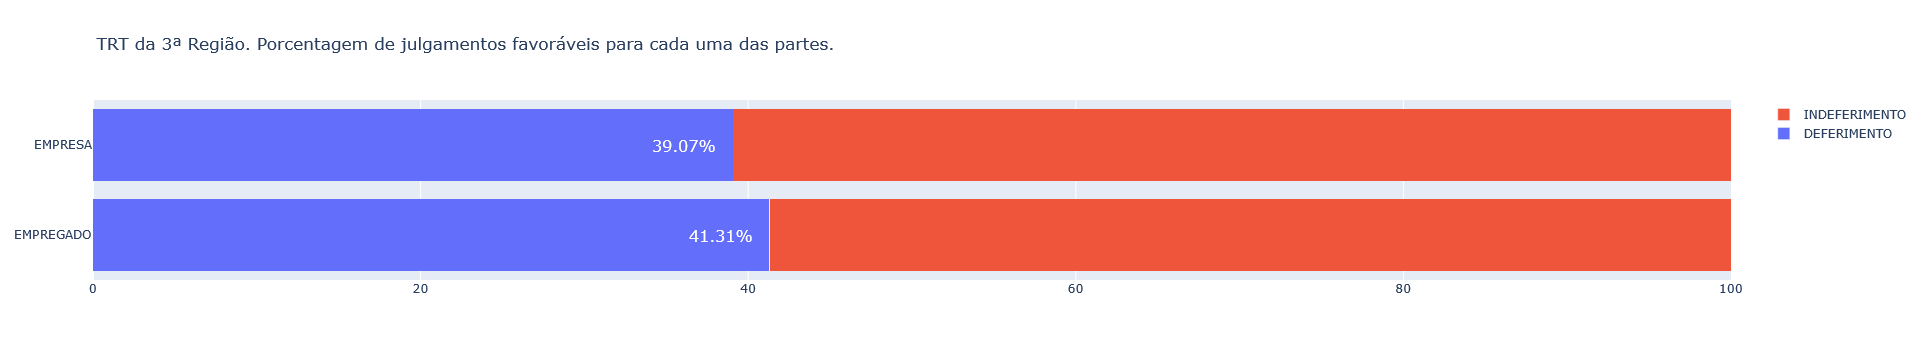

In [105]:
#DEFERIMENTO
trace1 = go.Bar(x = X_def,
                y = rotulos,  
                orientation="h",
                textposition='auto',
                textfont=dict(
        family="sans serif",
        size=18,
        color="black"),
                name="DEFERIMENTO" )
#INDEFERIMENTO
trace2 = go.Bar(x = X_indef,
                y = rotulos,
                orientation="h",
                textposition='auto',
                name="INDEFERIMENTO" )

layout = go.Layout( title="TRT da 3ª Região. Porcentagem de julgamentos favoráveis para cada uma das partes.",
                    barmode="stack",
                    barnorm="percent",                    
                    )

fig = go.Figure( data = [ trace1, trace2 ], layout=layout )

fig.add_annotation(
        y="EMPREGADO",
        x = ( porporcao_empregado*100 ) - 3,
        text=str( round( porporcao_empregado*100, 2) )+"%",
        showarrow=False,
        font=dict(
                size=16,
                color="#ffffff"
                ),
        )

fig.add_annotation(
        y="EMPRESA",
        x = ( porporcao_empresa*100 ) - 3,
        text=str( round( porporcao_empresa*100, 2) )+"%",
        showarrow=False,
        font=dict(
                size=16,
                color="#ffffff"
                ),
        )

fig.show()

### Interpretação
Do total de recursos que as <strong>EMPRESAS</strong> recorreram ao TRT da 3ª Região, <strong>39,27%</strong> foram DEFERIDOS. Considerando apenas sentenças em que houve recurso somente da EMPRESA.<BR>
Do total de recursos que as <strong>EMPREGADOS</strong> recorreram ao TRT da 3ª Região, <strong>50,24%</strong> foram DEFERIDOS. Considerando apenas sentenças em que houve recurso somente do EMPREGADO.<BR>

In [106]:
print( "Quantidade de processos analisados: "+str( len( df_limpo.loc[ _tribunal_TRT3 ] ) ) )

Quantidade de processos analisados: 10477


In [107]:
tipo_requerente_previsto_EMPREGADO = df_limpo["tipo_requerente_previsto"] == "EMPREGADO"
tipo_requerente_previsto_EMPRESA = df_limpo["tipo_requerente_previsto"] == "EMPRESA"
quantidade_EMPREGADO = len( df_limpo.loc[ _tribunal_TRT3 & tipo_requerente_previsto_EMPREGADO ] )
quantidade_EMPRESA = len( df_limpo.loc[ _tribunal_TRT3 & tipo_requerente_previsto_EMPRESA ] )
print( "Recorrente EMPREGADO. Quantidade de processos analisados: "+str( quantidade_EMPREGADO ) )
print( "Recorrente EMPRESA. Quantidade de processos analisados: "+str( quantidade_EMPRESA ) )

Recorrente EMPREGADO. Quantidade de processos analisados: 7349
Recorrente EMPRESA. Quantidade de processos analisados: 3128


## Teste estatístico: Two proportion z-test
### Interpretação

In [108]:
n_deferimento_empregado, n_indeferimento_empregado, n_deferimento_empresa, n_indeferimento_empresa =  pd.crosstab( df_limpo.loc[ _tribunal_TRT3 ].tipo_requerente_previsto, df_limpo.loc[ _tribunal_TRT3 ].deferimento_previsto ).to_numpy().flatten()
total_empregado = n_deferimento_empregado + n_indeferimento_empregado
total_empresa = n_deferimento_empresa + n_indeferimento_empresa
pvalue = proportion.test_proportions_2indep( n_deferimento_empregado, total_empregado, n_deferimento_empresa, total_empresa )[1]

In [109]:
print( "P-value: "+str(round(pvalue*100, 2) )+"%" )
if( pvalue < 0.05 ):
    print( "SIM, apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa." )
else:
    print( "NÃO, não apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa." )

P-value: 3.19%
SIM, apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa.


In [110]:
pvalue

0.03189451083979464

In [111]:
P1 = n_deferimento_empregado / total_empregado
P2 = n_deferimento_empresa / total_empresa
diff = P1 - P2
power = proportion.power_proportions_2indep( diff, P2, total_empregado,  total_empresa/total_empregado, alpha=0.05, value=0, alternative='two-sided', return_results=True).power
print( "Power: "+str(round(power*100, 2) )+"%" )
if( power < 0.8 ):
    print( "Nível inaceitável de força estatística. Risco considerável de ocorrer Type 2 error, ou seja, há risco de não haver diferença entre as proporções (se foi encontrada diferença)." )
else:
    print( "Nível aceitável de força estatística. Risco baixo de ocorrer Type 2 error, ou seja, há risco baixo de não haver diferença entre as proporções (se foi encontrada diferença)." )

Power: 79.28%
Nível inaceitável de força estatística. Risco considerável de ocorrer Type 2 error, ou seja, há risco de não haver diferença entre as proporções (se foi encontrada diferença).


## Teste de efeito estatístico: Cohen's H
### Interpretação

In [112]:
effectsize = proportion_effectsize( porporcao_empregado, porporcao_empresa )

In [113]:
print( "Índice Cohen's H: "+str(abs(round(effectsize*100, 2) ) )+"%" )
hNonDir = abs(effectsize)
if hNonDir < .20:
    print('Diferença estatística insignificante.')
elif hNonDir < .50:
    print('Diferença estatística pequena.')
elif hNonDir < .80:
    print('Diferença estatística média.')
else:
    print('Diferença estatística grande.')    

Índice Cohen's H: 4.58%
Diferença estatística insignificante.


# TRT 3 - Análise das Turmas Recursais individualmente

In [114]:
_tribunal_TRT3 = df_quantidades_TRT3["TRIBUNAL"] == "TRT3"
_polaridade_def = df_quantidades_TRT3["deferimento_previsto"] == "DEFERIMENTO"
_polaridade_indef = df_quantidades_TRT3["deferimento_previsto"] == "INDEFERIMENTO"

X_def = df_quantidades_TRT3.loc[ _tribunal_TRT3 & _polaridade_def , "QUANTIDADE" ]
Y_def_orgao = df_quantidades_TRT3.loc[ _tribunal_TRT3 & _polaridade_def , "ORGAO" ]
Y_def_recorrente = df_quantidades_TRT3.loc[ _tribunal_TRT3 & _polaridade_def , "tipo_requerente_previsto" ]

X_indef = df_quantidades_TRT3.loc[ _tribunal_TRT3 & _polaridade_indef , "QUANTIDADE" ]
Y_indef_orgao = df_quantidades_TRT3.loc[ _tribunal_TRT3 & _polaridade_indef , "ORGAO" ]
Y_indef_recorrente = df_quantidades_TRT3.loc[ _tribunal_TRT3 & _polaridade_indef , "tipo_requerente_previsto" ]

In [115]:
#deferido
trace1 = go.Bar(x = X_def,
                y = [ Y_def_orgao,
                      Y_def_recorrente ],  
                orientation="h",
                name="DEFERIMENTO" )
#indeferido
trace2 = go.Bar(x = X_indef,
                y = [ Y_indef_orgao,
                      Y_indef_recorrente ],
                orientation="h",
                name="INDEFERIMENTO" )

layout = go.Layout( 
    title="TRT da 3ª Região. Porcentagem de julgamentos favoráveis <br>para cada uma das partes em relação a cada Turma Recursal.",
    barmode="stack",
    barnorm="percent",
    margin=dict(l=400),
    width=1000,
    height=1000
    )

fig = go.Figure( data = [ trace1, trace2 ], layout=layout )

In [116]:
_tribunal_TRT3 = df_quantidades_percentuais_TRT3["TRIBUNAL"] == "TRT3"
orgaos = df_quantidades_percentuais_TRT3.loc[ _tribunal_TRT3, "ORGAO"].to_numpy()
percentuais_deferimento = df_quantidades_percentuais_TRT3.loc[ _tribunal_TRT3, "percentual_deferido"].to_numpy()
tipo_parte = df_quantidades_percentuais_TRT3.loc[ _tribunal_TRT3, "tipo_requerente_previsto"].to_numpy()

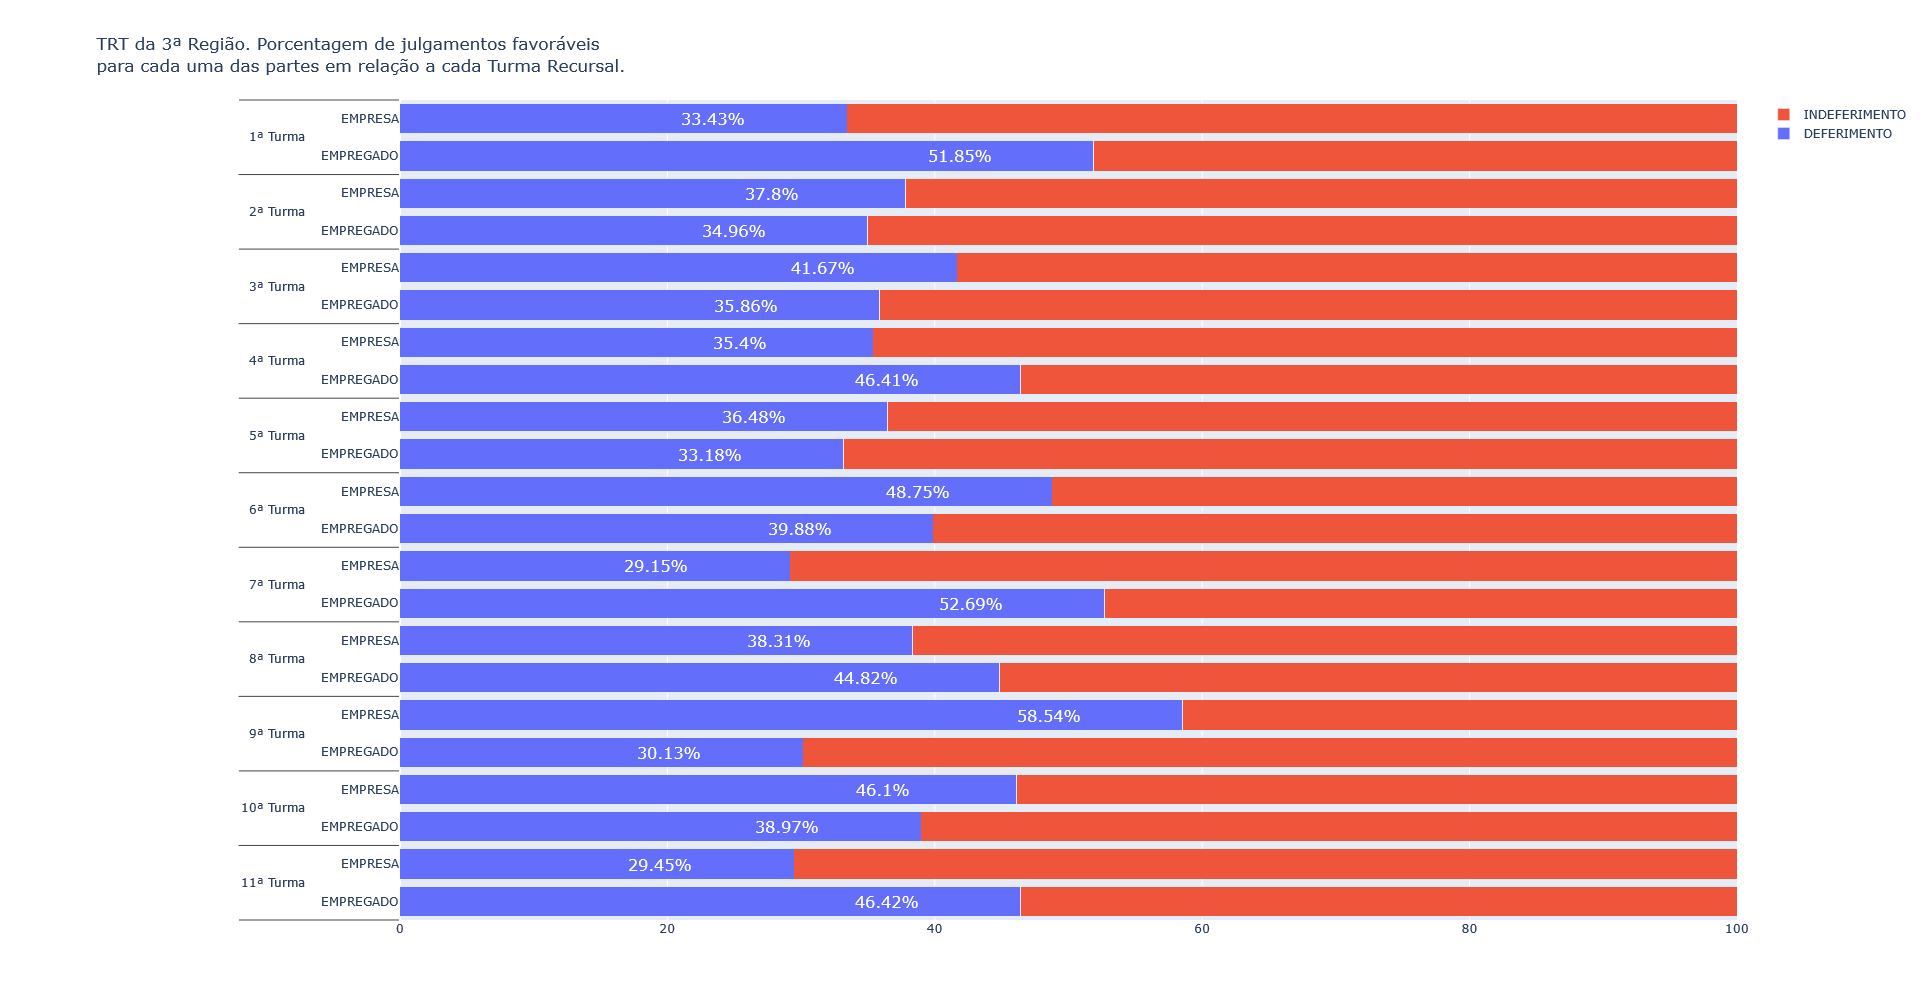

In [117]:
for i in range( len( orgaos ) ):
    fig.add_annotation(
            y= [ orgaos[i], tipo_parte[i] ],
            x = ( percentuais_deferimento[i] ) - 10,
            text=str( round( percentuais_deferimento[i], 2) )+"%",
            showarrow=False,
            font=dict(
                    size=16,
                    color="#ffffff"
                    ),
            )

fig.show()

### Interpretação
O gráfico anterior apresenta as porcentagens de deferimento em relação a cada Turma Recursal em relação a parte sendo empregado e empresa.

## Teste estatístico: Two proportion z-test e Teste de efeito estatístico: Cohen's H para cada Turma Recursal
### Interpretação

In [118]:
df_relatorio_trt3 = testes_estatisticos_turmas( "TRT3", df_quantidades_TRT3 )

=======================================> 1ª Turma
Quantidade de processos analisados de EMPRESAS: 356
Quantidade de processos analisados de EMPREGADOS: 702
===> P-value: 0.0%
SIM, apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa.
===> Power: 100.0%
Nível aceitável de força estatística. Risco baixo de ocorrer Type 2 error, ou seja, há risco baixo de não haver diferença entre as proporções (se foi encontrada diferença).
===> Índice Cohen's H: 37.49%
Diferença estatística pequena.

=======================================> 2ª Turma
Quantidade de processos analisados de EMPRESAS: 291
Quantidade de processos analisados de EMPREGADOS: 615
===> P-value: 40.09%
NÃO, não apresenta diferença estatística entre a proporção de deferimentos para empregado e para empresa.
===> Power: 17.89%
Nível inaceitável de força estatística. Risco considerável de ocorrer Type 2 error, ou seja, há risco de não haver diferença entre as proporções (se foi encontrada dif

In [119]:
df_relatorio_trt3

,TRIBUNAL,TURMA RECURSAL,TOTAL DE PROCESSOS,PVALUE,PVALUE INTERPRETACAO,POWER,POWER INTERPRETAÇÃO,EFFECT,EFFECT INTERPRETACAO
0,TRT3,1ª Turma,1058,0.0000,HÁ DIFERENÇA,1.0000,ACEITÁVEL,0.3749,PEQUENA
0,TRT3,2ª Turma,906,0.4009,NÃO HÁ DIFERENÇA,0.1789,INACEITÁVEL,0.0591,INSIGNIFICANTE
0,TRT3,3ª Turma,938,0.1047,NÃO HÁ DIFERENÇA,0.5978,INACEITÁVEL,0.1193,INSIGNIFICANTE
0,TRT3,4ª Turma,931,0.0014,HÁ DIFERENÇA,0.9803,ACEITÁVEL,0.2245,PEQUENA
0,TRT3,5ª Turma,889,0.3495,NÃO HÁ DIFERENÇA,0.2372,INACEITÁVEL,0.0692,INSIGNIFICANTE
0,TRT3,6ª Turma,973,0.0116,HÁ DIFERENÇA,0.9142,ACEITÁVEL,0.1788,INSIGNIFICANTE
0,TRT3,7ª Turma,1025,0.0000,HÁ DIFERENÇA,1.0000,ACEITÁVEL,0.4839,PEQUENA
0,TRT3,8ª Turma,850,0.0762,NÃO HÁ DIFERENÇA,0.6205,INACEITÁVEL,0.1321,INSIGNIFICANTE
0,TRT3,9ª Turma,1016,0.0000,HÁ DIFERENÇA,1.0000,ACEITÁVEL,0.5803,MÉDIA
0,TRT3,10ª Turma,957,0.0394,HÁ DIFERENÇA,0.7470,INACEITÁVEL,0.1443,INSIGNIFICANTE


In [123]:
df_relatorio_trt3.to_csv("df_relatorio_trt3.csv", sep=',', encoding='utf-8', quotechar='"', decimal=',')

In [120]:
df_relatorio_trt3.describe()

,TOTAL DE PROCESSOS,PVALUE,POWER,EFFECT
count,11.000000,11.000000,11.000000,11.000000
mean,952.454545,0.089427,0.752355,0.247109
std,62.108556,0.146068,0.309678,0.175124
min,850.000000,0.000000,0.178900,0.059100
25%,918.500000,0.000000,0.609150,0.125700
50%,938.000000,0.011600,0.914200,0.178800
75%,994.500000,0.090450,1.000000,0.363350
max,1058.000000,0.400900,1.000000,0.580300


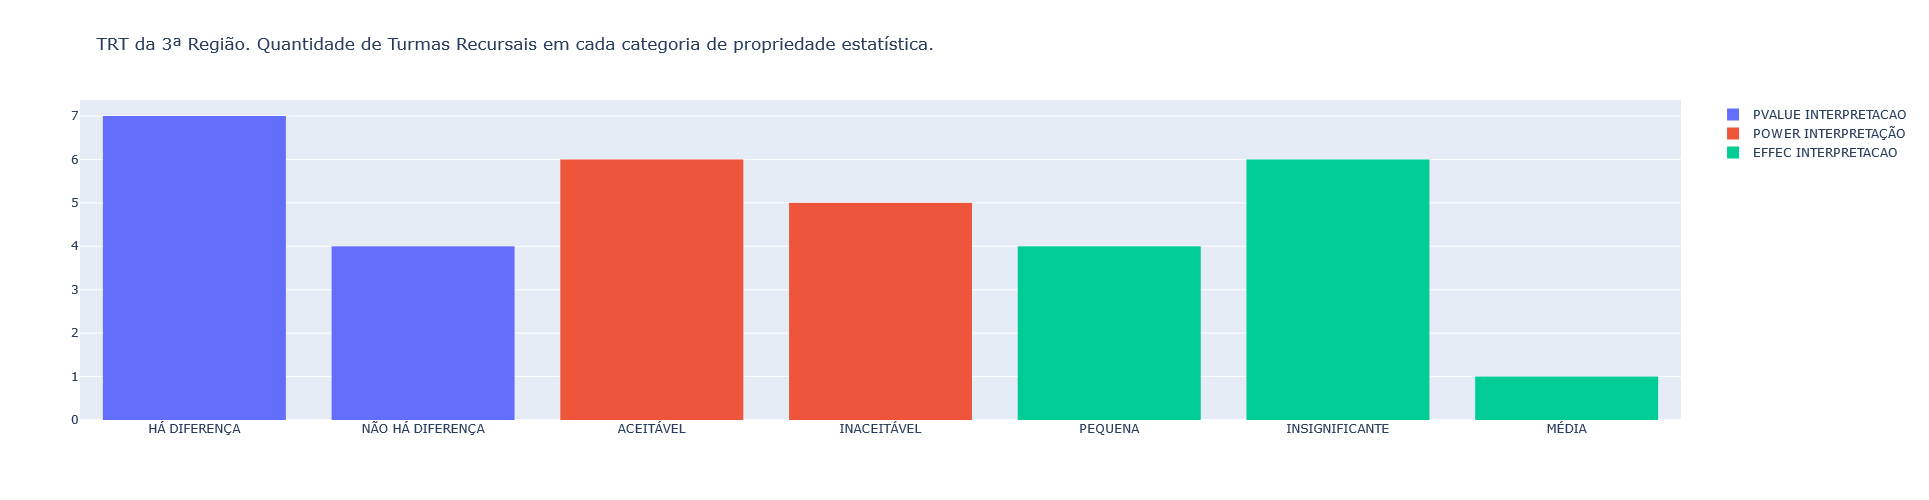

In [121]:
x_pvalue = df_relatorio_trt3["PVALUE INTERPRETACAO"]
x_power = df_relatorio_trt3["POWER INTERPRETAÇÃO"]
x_effect = df_relatorio_trt3["EFFECT INTERPRETACAO"]

trace1 = go.Histogram(
    x=x_pvalue,
    name="PVALUE INTERPRETACAO",
)

trace2 = go.Histogram(
    x=x_power,
    name="POWER INTERPRETAÇÃO",
)

trace3 = go.Histogram(
    x=x_effect,
    name="EFFEC INTERPRETACAO",
)

layout = go.Layout( title="TRT da 3ª Região. Quantidade de Turmas Recursais em cada categoria de propriedade estatística.",
                   #width=1000,
                   height=500
                  )

fig = go.Figure( data = [ trace1, trace2, trace3 ], layout=layout )
fig.show()

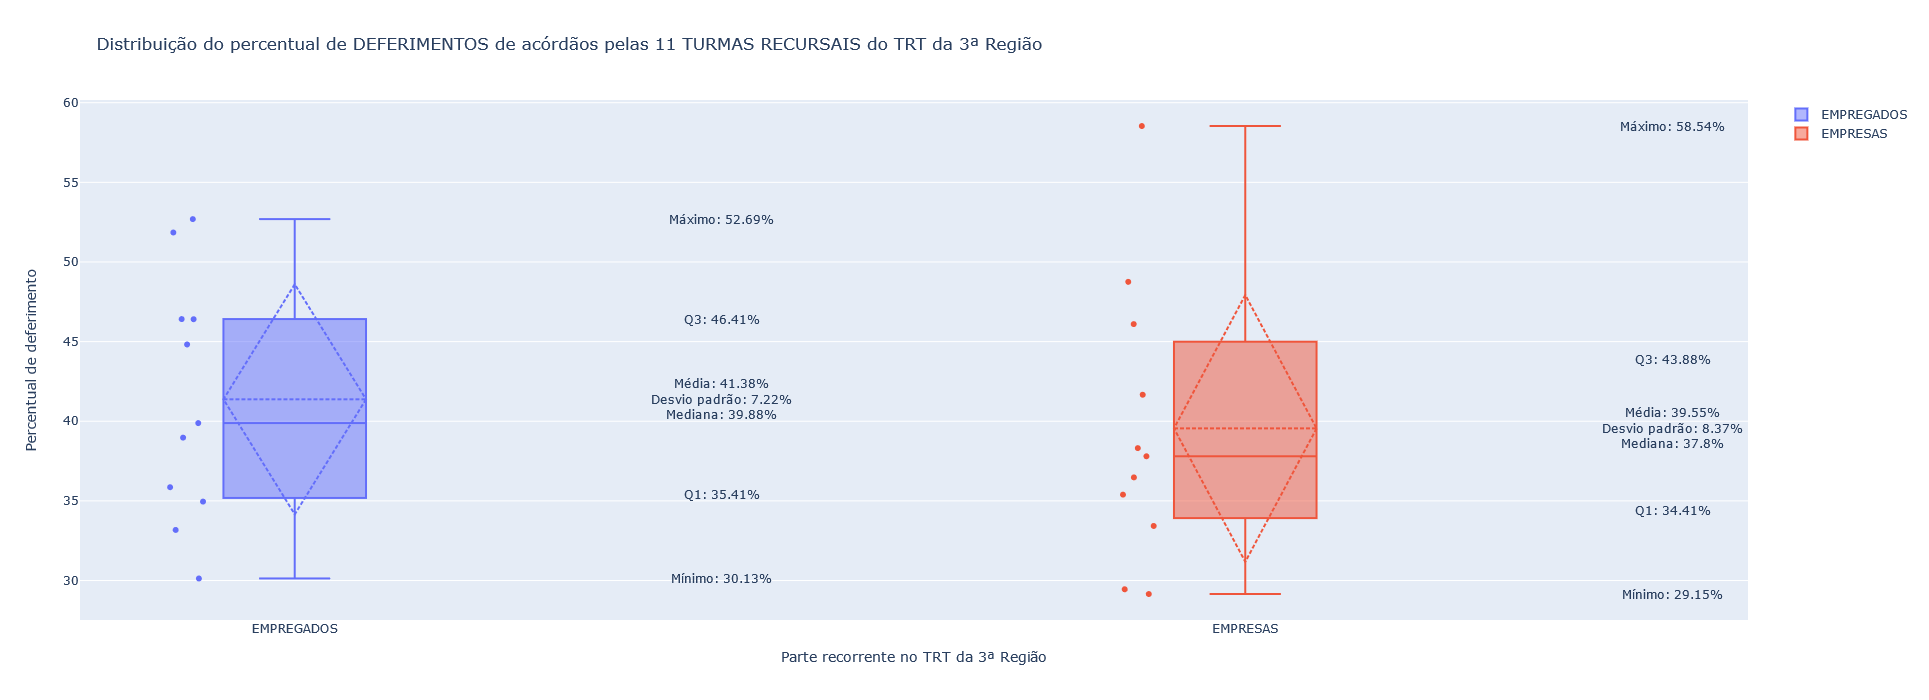

In [122]:
df_quantidades_percentuais = df_quantidades_percentuais_TRT3

_tipo_requerente_EMPREGADO = df_quantidades_percentuais["tipo_requerente_previsto"] == "EMPREGADO"
_tipo_requerente_EMPRESA = df_quantidades_percentuais["tipo_requerente_previsto"] == "EMPRESA"
_tribunal = df_quantidades_percentuais["TRIBUNAL"] == "TRT3"

layout = go.Layout(
    title='Distribuição do percentual de DEFERIMENTOS de acórdãos pelas 11 TURMAS RECURSAIS do TRT da 3ª Região',
    yaxis_title_text='Percentual de deferimento',
    xaxis_title_text='Parte recorrente no TRT da 3ª Região',
    width=1000,
    height=700,
    #boxgap=1
)

box_width = 0.15

########## EMPREGADOS
y_empregado = df_quantidades_percentuais.loc[ _tribunal & _tipo_requerente_EMPREGADO, "percentual_deferido"]

trace1 = go.Box(
    y=y_empregado,
    name='EMPREGADOS',
    boxmean='sd', # represent mean and standard deviation
    boxpoints='all',
    width=box_width
)

########## EMPRESAS
y_empresa = df_quantidades_percentuais.loc[ _tribunal & _tipo_requerente_EMPRESA, "percentual_deferido"]

trace2 = go.Box(
    y=y_empresa,
    name='EMPRESAS',
    boxmean='sd', # represent mean and standard deviation
    boxpoints='all',
    width=box_width
)

fig = go.Figure( data = [ trace1, trace2 ], layout=layout )

########## LEGENDAS EMPREGADOS
for legenda in zip( ["Mínimo","Q1","Mediana","Q3","Máximo"], df_quantidades_percentuais.loc[ _tribunal & _tipo_requerente_EMPREGADO, "percentual_deferido"].quantile([0,0.25,0.5,0.75,1]) ):
    if(legenda[0] != "Mediana"):
        fig.add_annotation(
            y=legenda[1],
            x=0.45,
            text=legenda[0] + ": " + str(round(legenda[1], 2)) + "%",
            showarrow=False
            )

media_empregado = np.mean(y_empregado)
mediana_empregado = np.median(y_empregado)
desvio_padrao_empregado = np.std(y_empregado)

fig.add_annotation(
        y=media_empregado,
        x=0.45,
        text="Média: " + str(round(media_empregado, 2)) + "%<br>Desvio padrão: " + str(round(desvio_padrao_empregado, 2)) + "%<br>Mediana: " + str(round(mediana_empregado, 2)) + "%<br>",
        showarrow=False
        )

########## LEGENDAS EMPRESAS
for legenda in zip( ["Mínimo","Q1","Mediana","Q3","Máximo"], df_quantidades_percentuais.loc[ _tribunal & _tipo_requerente_EMPRESA, "percentual_deferido"].quantile([0,0.25,0.5,0.75,1]) ):
    if(legenda[0] != "Mediana"):
        fig.add_annotation(
            y=legenda[1],
            x=1.45,
            text=legenda[0] + ": " + str(round(legenda[1], 2)) + "%",
            showarrow=False
            )

media_empresa = np.mean(y_empresa)
mediana_empresa = np.median(y_empresa)
desvio_padrao_empresa = np.std(y_empresa)
fig.add_annotation(
        y=media_empresa,
        x=1.45,
        text="Média: " + str(round(media_empresa, 2)) + "%<br>Desvio padrão: " + str(round(desvio_padrao_empresa, 2)) + "%<br>Mediana: " + str(round(mediana_empresa, 2)) + "%<br>",
        showarrow=False
        )

fig.show()